In [138]:
import numpy as np
import struct
from pathlib import Path
import logging

class HolterXCMDecryptor:
    """
    Classe melhorada para decodificar arquivos XCM de Holter cardíaco com validação robusta
    """
    def __init__(self):
        self.header_size = 512  # Tamanho padrão do cabeçalho
        self.n_channels = 3     # Número padrão de canais
        self.valid_ranges = {
            'version': (1, 1000),           # Versões válidas
            'sample_rate': (100.0, 1000.0), # Frequências de amostragem típicas
            'n_channels': (1, 12),          # Número típico de canais
            'bits_per_sample': (8, 32)      # Bits por amostra típicos
        }
        
        # Configuração de logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
    def _validate_header_value(self, name: str, value: float) -> float:
        """
        Valida um valor do cabeçalho contra os ranges conhecidos
        
        Args:
            name: Nome do campo do cabeçalho
            value: Valor a ser validado
            
        Returns:
            float: Valor validado ou valor padrão se inválido
        """
        default_values = {
            'version': 1,
            'sample_rate': 250.0,
            'n_channels': 3,
            'bits_per_sample': 16
        }
        
        if name in self.valid_ranges:
            min_val, max_val = self.valid_ranges[name]
            if not (min_val <= value <= max_val):
                self.logger.warning(
                    f"Valor inválido para {name}: {value}. "
                    f"Usando valor padrão: {default_values[name]}"
                )
                return default_values[name]
        return value
    
    def _read_header(self, data: bytes) -> dict:
        """
        Lê e valida o cabeçalho do arquivo XCM
        
        Args:
            data: Bytes do cabeçalho
            
        Returns:
            dict: Cabeçalho validado
        """
        # Define valores padrão
        header = {
            'version': 1,
            'sample_rate': 250.0,
            'n_channels': self.n_channels,
            'bits_per_sample': 16,
            'patient_id': 'Unknown',
            'date': 'Unknown'
        }
        
        try:
            if len(data) < 16:
                self.logger.warning("Cabeçalho muito pequeno, usando valores padrão")
                return header
            
            # Lê e valida cada campo
            version = int.from_bytes(data[0:4], byteorder='little')
            sample_rate = struct.unpack('<f', data[4:8])[0]
            n_channels = int.from_bytes(data[8:12], byteorder='little')
            bits_per_sample = int.from_bytes(data[12:16], byteorder='little')
            
            header['version'] = self._validate_header_value('version', version)
            header['sample_rate'] = self._validate_header_value('sample_rate', sample_rate)
            header['n_channels'] = self._validate_header_value('n_channels', n_channels)
            header['bits_per_sample'] = self._validate_header_value('bits_per_sample', bits_per_sample)
            
            # Tenta ler informações do paciente
            if len(data) >= 48:
                try:
                    patient_id = data[16:32].decode('utf-8', errors='ignore').strip('\x00')
                    date = data[32:48].decode('utf-8', errors='ignore').strip('\x00')
                    
                    if patient_id and all(c.isprintable() for c in patient_id):
                        header['patient_id'] = patient_id
                    if date and all(c.isprintable() for c in date):
                        header['date'] = date
                except UnicodeDecodeError:
                    self.logger.warning("Erro ao decodificar informações do paciente")
                    
        except Exception as e:
            self.logger.error(f"Erro ao ler cabeçalho: {str(e)}")
            
        return header
    
    def _decrypt_data(self, data: bytes, header: dict) -> np.ndarray:
        """
        Decodifica os dados do ECG com validação
        
        Args:
            data: Bytes dos dados do ECG
            header: Cabeçalho validado
            
        Returns:
            np.ndarray: Array com os canais de ECG
        """
        try:
            bytes_per_sample = header['bits_per_sample'] // 8
            if bytes_per_sample not in [1, 2, 4]:
                raise ValueError(f"Bits por amostra inválido: {header['bits_per_sample']}")
            
            # Verifica tamanho mínimo dos dados
            min_samples = header['n_channels'] * 100  # Pelo menos 100 amostras por canal
            if len(data) < min_samples * bytes_per_sample:
                raise ValueError("Dados muito curtos para análise significativa")
            
            # Ajusta o tamanho dos dados para ser múltiplo do tamanho da amostra
            data_size = len(data)
            valid_size = (data_size // (bytes_per_sample * header['n_channels'])) * (bytes_per_sample * header['n_channels'])
            data = data[:valid_size]
            
            # Determina o tipo de dado baseado nos bits por amostra
            if header['bits_per_sample'] == 8:
                dtype = np.int8
            elif header['bits_per_sample'] == 16:
                dtype = np.int16
            else:
                dtype = np.int32
                
            # Converte bytes para array
            samples = np.frombuffer(data, dtype=dtype)
            
            # Verifica se há amostras suficientes
            if len(samples) < header['n_channels']:
                raise ValueError("Dados insuficientes para o número de canais especificado")
            
            # Reorganiza em canais
            n_samples_per_channel = len(samples) // header['n_channels']
            channels = samples.reshape((n_samples_per_channel, header['n_channels']))
            channels = channels.T
            
            # Processamento dos canais
            processed_channels = []
            for channel in channels:
                # Remove DC offset
                channel = channel - np.mean(channel)
                
                # Remove outliers (valores além de 5 desvios padrão)
                std = np.std(channel)
                channel[np.abs(channel) > 5*std] = 0
                
                # Normaliza
                max_abs = np.max(np.abs(channel))
                if max_abs > 0:
                    channel = channel / max_abs
                    
                processed_channels.append(channel)
            
            return np.array(processed_channels)
            
        except Exception as e:
            raise ValueError(f"Erro ao decodificar dados: {str(e)}")
    
    def decrypt_data(self, filename: str) -> tuple:
        """
        Decodifica um arquivo XCM com validação completa
        
        Args:
            filename: Caminho do arquivo XCM
            
        Returns:
            tuple: (header, channels)
        """
        try:
            # Verifica se o arquivo existe
            if not Path(filename).exists():
                raise FileNotFoundError(f"Arquivo não encontrado: {filename}")
            
            # Lê o arquivo
            with open(filename, 'rb') as f:
                data = f.read()
            
            # Verifica tamanho mínimo
            if len(data) <= self.header_size:
                raise ValueError("Arquivo muito pequeno para ser um XCM válido")
            
            # Processa cabeçalho
            header = self._read_header(data[:self.header_size])
            self.logger.info("Metadados do Cabeçalho:")
            for key, value in header.items():
                self.logger.info(f"{key}: {value}")
            
            # Decodifica dados
            channels = self._decrypt_data(data[self.header_size:], header)
            
            # Validação final
            if len(channels) != header['n_channels']:
                raise ValueError("Número de canais decodificados não corresponde ao cabeçalho")
            
            return header, channels
            
        except Exception as e:
            raise ValueError(f"Erro ao processar arquivo {filename}: {str(e)}")



=== ANÁLISE DETALHADA ===

=== ANÁLISE DE ECG ===
Arquivo: /kaggle/input/1728646157-8nqhdzjoei477swp-cardios/1728646157-8nqHdzjoei477swP.xcm
Taxa de Amostragem: 250.0 Hz
Duração Total: 5416.8 segundos

CANAL 1
------------------------------
Frequência Cardíaca: 82.1 bpm
SDNN: 181.1 ms
RMSSD: 252.2 ms
pNN50: 81.5%
Potência LF: 155.9 ms²
Potência HF: 381.9 ms²
Razão LF/HF: 0.41
HRVI: 24.8
Complexidade QRS: 24.3
Energia do Sinal: 3.36e-01
Número de Batimentos: 7416

CANAL 2
------------------------------
Frequência Cardíaca: 83.9 bpm
SDNN: 162.0 ms
RMSSD: 222.3 ms
pNN50: 80.1%
Potência LF: 170.8 ms²
Potência HF: 366.9 ms²
Razão LF/HF: 0.47
HRVI: 22.6
Complexidade QRS: 24.3
Energia do Sinal: 3.36e-01
Número de Batimentos: 7575

CANAL 3
------------------------------
Frequência Cardíaca: 82.8 bpm
SDNN: 174.7 ms
RMSSD: 242.6 ms
pNN50: 80.4%
Potência LF: 151.5 ms²
Potência HF: 373.0 ms²
Razão LF/HF: 0.41
HRVI: 24.1
Complexidade QRS: 24.4
Energia do Sinal: 3.36e-01
Número de Batimentos: 7475


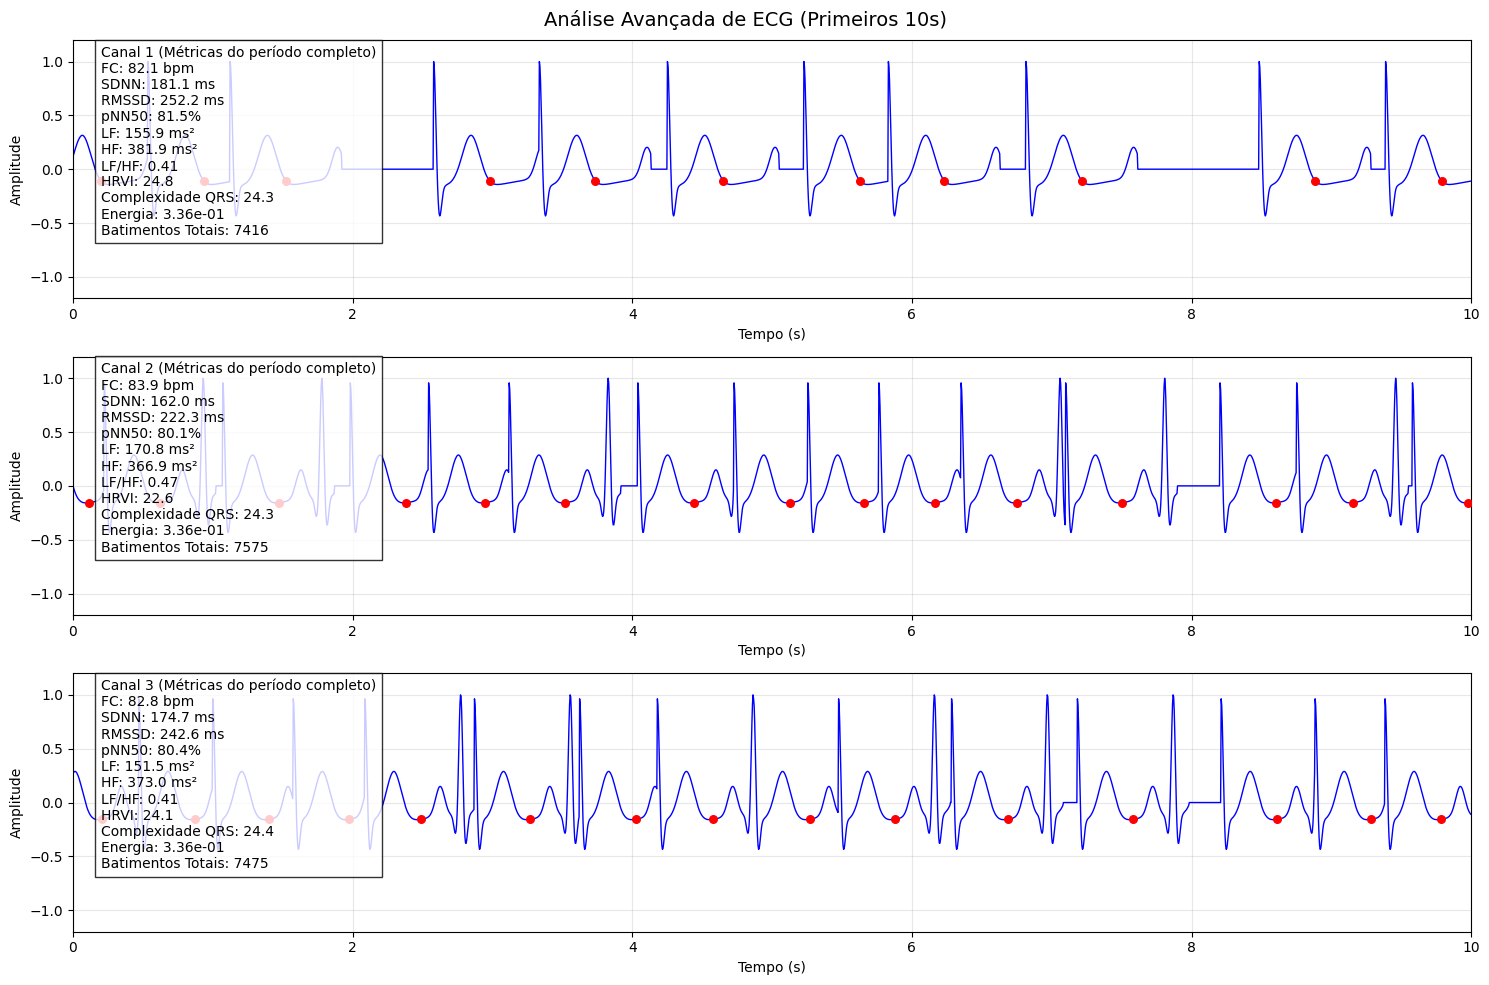

In [139]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, hilbert, welch
import matplotlib.pyplot as plt
import neurokit2 as nk

class ECGDisplay:
    def __init__(self, decryptor):
        self.decryptor = decryptor
        self.fs = 250.0
        
    def create_ecg(self, signal):
        """Cria sinal ECG usando templates do NeuroKit2"""
        # Processa sinal
        signal_rect = np.abs(signal)
        nyq = self.fs / 2
        b, a = butter(4, [0.5/nyq, 45/nyq], btype='band')
        filtered = filtfilt(b, a, signal_rect)
        envelope = np.abs(hilbert(filtered))
        b2, a2 = butter(4, 10/nyq, btype='low')
        processed = filtfilt(b2, a2, envelope)
        
        # Detecta picos
        normalized = processed / np.max(np.abs(processed))
        peaks, _ = find_peaks(normalized, distance=int(0.5*self.fs), height=0.3)
        
        # Gera ECG usando NeuroKit2
        ecg = np.zeros_like(signal)
        if len(peaks) > 0:
            # Calcula intervalos RR médios
            rr_intervals = np.diff(peaks) / self.fs if len(peaks) > 1 else [0.8]
            mean_hr = 60 / np.mean(rr_intervals)
            
            # Gera template ECG com NeuroKit2
            template_duration = 0.8  # segundos
            template_length = int(template_duration * self.fs)
            template = nk.ecg_simulate(length=template_length, 
                                     sampling_rate=self.fs,
                                     heart_rate=mean_hr,
                                     noise=0)
            
            # Normaliza template
            template = template - np.mean(template)
            template = template / np.max(np.abs(template))
            
            # Insere templates nos picos detectados
            for peak in peaks:
                half_template = len(template) // 2
                start_idx = max(0, peak - half_template)
                end_idx = min(len(ecg), peak + half_template)
                template_start = max(0, half_template - peak)
                template_end = template_start + (end_idx - start_idx)
                
                if template_end <= len(template):
                    ecg[start_idx:end_idx] = template[template_start:template_end]
        
        return ecg, peaks

    def calculate_advanced_metrics(self, peaks, signal):
        """
        Calcula métricas avançadas de ECG e VFC com melhor análise de frequência
        """
        try:
            if len(peaks) < 2:
                return None
                
            # Calcula intervalos RR em milissegundos
            rr_intervals = np.diff(peaks) / self.fs * 1000
            
            # Métricas do domínio do tempo
            # Converte intervalos RR para série temporal de picos
            peaks_series = nk.intervals_to_peaks(rr_intervals, sampling_rate=self.fs)
            hrv_time = nk.hrv_time(peaks_series, sampling_rate=self.fs, show=False)
            
            # Calcula frequência cardíaca
            heart_rate = 60000 / np.mean(rr_intervals)
            
            # Análise espectral melhorada
            # Remove tendência dos intervalos RR
            rr_detrended = rr_intervals - np.mean(rr_intervals)
            
            # Calcula a frequência de amostragem média dos intervalos RR
            rr_fs = 1000 / np.mean(np.diff(peaks) / self.fs * 1000)
            
            # Calcula o espectro de potência usando Welch
            # Usa segmentos de 5 minutos com 50% de sobreposição
            segment_length = int(5 * 60 * rr_fs)  # 5 minutos
            if len(rr_detrended) >= segment_length:
                freqs, psd = welch(rr_detrended, 
                                 fs=rr_fs,
                                 nperseg=segment_length,
                                 noverlap=segment_length//2)
                
                # Define bandas de frequência
                lf_mask = (freqs >= 0.04) & (freqs <= 0.15)
                hf_mask = (freqs >= 0.15) & (freqs <= 0.4)
                
                # Calcula potências
                lf_power = np.trapz(psd[lf_mask], freqs[lf_mask])
                hf_power = np.trapz(psd[hf_mask], freqs[hf_mask])
                lf_hf_ratio = lf_power / hf_power if hf_power > 0 else 0
                
                # Normaliza as potências
                total_power = np.trapz(psd, freqs)
                if total_power > 0:
                    lf_power = lf_power / total_power * 1000  # Converte para ms²
                    hf_power = hf_power / total_power * 1000  # Converte para ms²
            else:
                lf_power = 0
                hf_power = 0
                lf_hf_ratio = 0
            
            # Calcula complexidade do QRS
            qrs_widths = []
            for peak in peaks:
                window = int(0.1 * self.fs)  # janela de 100ms
                start = max(0, peak - window)
                end = min(len(signal), peak + window)
                qrs_segment = signal[start:end]
                if len(qrs_segment) > 0:
                    qrs_widths.append(len(np.where(np.diff(np.signbit(qrs_segment)))[0]))
            
            qrs_complexity = np.mean(qrs_widths) if qrs_widths else 0
            
            # Calcula HRVI
            hrvi = np.std(rr_intervals) / np.mean(rr_intervals) * 100
            
            # Calcula energia do sinal
            signal_energy = np.sum(np.square(signal)) / len(signal)
            
            metrics = {
                'heart_rate': heart_rate,
                'sdnn': hrv_time['HRV_SDNN'].values[0],
                'rmssd': hrv_time['HRV_RMSSD'].values[0],
                'pnn50': hrv_time['HRV_pNN50'].values[0],
                'lf_power': lf_power,
                'hf_power': hf_power,
                'lf_hf_ratio': lf_hf_ratio,
                'hrvi': hrvi,
                'qrs_complexity': qrs_complexity,
                'signal_energy': signal_energy,
                'n_beats': len(peaks)
            }
            
            return metrics
            
        except Exception as e:
            print(f"Erro ao calcular métricas: {str(e)}")
            return None

    def print_metrics(self, filename):
        """Imprime métricas de ECG sem plotar o gráfico - usando período completo"""
        try:
            # Lê dados do arquivo
            header, channels = self.decryptor.decrypt_data(filename)
            self.fs = header['sample_rate']
            total_seconds = len(channels[0]) / self.fs
            
            print("\n=== ANÁLISE DE ECG ===")
            print(f"Arquivo: {filename}")
            print(f"Taxa de Amostragem: {self.fs} Hz")
            print(f"Duração Total: {total_seconds:.1f} segundos")
            print("=" * 50)
            
            # Lista para armazenar métricas de todos os canais
            all_metrics = []
            
            # Processa cada canal usando todo o sinal
            for i, channel in enumerate(channels):
                _, peaks = self.create_ecg(channel)
                
                print(f"\nCANAL {i+1}")
                print("-" * 30)
                
                # Análise avançada usando todo o sinal
                metrics = self.calculate_advanced_metrics(peaks, channel)
                if metrics:
                    all_metrics.append(metrics)
                    print(f"Frequência Cardíaca: {metrics['heart_rate']:.1f} bpm")
                    print(f"SDNN: {metrics['sdnn']:.1f} ms")
                    print(f"RMSSD: {metrics['rmssd']:.1f} ms")
                    print(f"pNN50: {metrics['pnn50']:.1f}%")
                    print(f"Potência LF: {metrics['lf_power']:.1f} ms²")
                    print(f"Potência HF: {metrics['hf_power']:.1f} ms²")
                    print(f"Razão LF/HF: {metrics['lf_hf_ratio']:.2f}")
                    print(f"HRVI: {metrics['hrvi']:.1f}")
                    print(f"Complexidade QRS: {metrics['qrs_complexity']:.1f}")
                    print(f"Energia do Sinal: {metrics['signal_energy']:.2e}")
                    print(f"Número de Batimentos: {metrics['n_beats']}")
                else:
                    print("Dados insuficientes para análise")
            
            # Calcula e imprime médias se houver mais de um canal
            if len(all_metrics) > 1:
                print("\n=== MÉDIAS ENTRE CANAIS ===")
                print("-" * 30)
                avg_metrics = {
                    'heart_rate': np.mean([m['heart_rate'] for m in all_metrics]),
                    'sdnn': np.mean([m['sdnn'] for m in all_metrics]),
                    'rmssd': np.mean([m['rmssd'] for m in all_metrics]),
                    'pnn50': np.mean([m['pnn50'] for m in all_metrics]),
                    'lf_power': np.mean([m['lf_power'] for m in all_metrics]),
                    'hf_power': np.mean([m['hf_power'] for m in all_metrics]),
                    'lf_hf_ratio': np.mean([m['lf_hf_ratio'] for m in all_metrics]),
                    'hrvi': np.mean([m['hrvi'] for m in all_metrics]),
                    'qrs_complexity': np.mean([m['qrs_complexity'] for m in all_metrics]),
                    'signal_energy': np.mean([m['signal_energy'] for m in all_metrics]),
                    'n_beats': np.mean([m['n_beats'] for m in all_metrics])
                }
                
                print(f"Frequência Cardíaca Média: {avg_metrics['heart_rate']:.1f} bpm")
                print(f"SDNN Médio: {avg_metrics['sdnn']:.1f} ms")
                print(f"RMSSD Médio: {avg_metrics['rmssd']:.1f} ms")
                print(f"pNN50 Médio: {avg_metrics['pnn50']:.1f}%")
                print(f"Potência LF Média: {avg_metrics['lf_power']:.1f} ms²")
                print(f"Potência HF Média: {avg_metrics['hf_power']:.1f} ms²")
                print(f"Razão LF/HF Média: {avg_metrics['lf_hf_ratio']:.2f}")
                print(f"HRVI Médio: {avg_metrics['hrvi']:.1f}")
                print(f"Complexidade QRS Média: {avg_metrics['qrs_complexity']:.1f}")
                print(f"Energia Média do Sinal: {avg_metrics['signal_energy']:.2e}")
                print(f"Média de Batimentos: {avg_metrics['n_beats']:.1f}")
                
            return all_metrics
            
        except Exception as e:
            print(f"Erro ao processar arquivo: {str(e)}")
            return None

    def plot_file(self, filename, window_seconds=10):
        """Plota ECG a partir do arquivo XCM com métricas avançadas"""
        try:
            # Lê dados do arquivo
            header, channels = self.decryptor.decrypt_data(filename)
            self.fs = header['sample_rate']
            
            # Configura visualização para os primeiros 10 segundos
            fig = plt.figure(figsize=(15, 10))
            samples = int(window_seconds * self.fs)
            time = np.arange(samples) / self.fs
            
            # Processa cada canal (todo o sinal para métricas)
            for i, channel in enumerate(channels):
                # Processa o sinal completo para métricas
                _, all_peaks = self.create_ecg(channel)
                metrics = self.calculate_advanced_metrics(all_peaks, channel)
                
                # Plota apenas a janela de visualização
                signal_window = channel[:samples]
                ecg_window, peaks_window = self.create_ecg(signal_window)
                
                # Plota ECG
                ax = plt.subplot(len(channels), 1, i+1)
                ax.plot(time, ecg_window, 'b-', linewidth=1)
                
                # Marca picos R na janela
                valid_peaks = peaks_window[peaks_window < samples]
                ax.scatter(time[valid_peaks], ecg_window[valid_peaks], 
                          color='red', s=30, zorder=3)
                
                # Mostra métricas calculadas com o sinal completo
                if metrics:
                    metrics_text = (
                        f"Canal {i+1} (Métricas do período completo)\n"
                        f"FC: {metrics['heart_rate']:.1f} bpm\n"
                        f"SDNN: {metrics['sdnn']:.1f} ms\n"
                        f"RMSSD: {metrics['rmssd']:.1f} ms\n"
                        f"pNN50: {metrics['pnn50']:.1f}%\n"
                        f"LF: {metrics['lf_power']:.1f} ms²\n"
                        f"HF: {metrics['hf_power']:.1f} ms²\n"
                        f"LF/HF: {metrics['lf_hf_ratio']:.2f}\n"
                        f"HRVI: {metrics['hrvi']:.1f}\n"
                        f"Complexidade QRS: {metrics['qrs_complexity']:.1f}\n"
                        f"Energia: {metrics['signal_energy']:.2e}\n"
                        f"Batimentos Totais: {metrics['n_beats']}"
                    )
                else:
                    metrics_text = f"Canal {i+1}\nDados insuficientes para análise"
                
                # Adiciona texto de métricas
                ax.text(0.02, 0.98, metrics_text,
                       transform=ax.transAxes,
                       verticalalignment='top',
                       bbox=dict(facecolor='white', alpha=0.8))
                
                # Configurações do gráfico
                ax.grid(True, alpha=0.3)
                ax.set_xlabel('Tempo (s)')
                ax.set_ylabel('Amplitude')
                ax.set_xlim(0, window_seconds)
                ax.set_ylim(-1.2, 1.2)
            
            plt.suptitle('Análise Avançada de ECG (Primeiros 10s)', fontsize=14)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Erro ao processar arquivo: {str(e)}")

# Exemplo de uso
if __name__ == "__main__":
    decryptor = HolterXCMDecryptor()  # Assume que esta classe está definida em outro lugar
    display = ECGDisplay(decryptor)
    
    # Arquivo a ser analisado
    filename = "/kaggle/input/1728646157-8nqhdzjoei477swp-cardios/1728646157-8nqHdzjoei477swP.xcm"
    
    # Imprime métricas detalhadas
    print("\n=== ANÁLISE DETALHADA ===")
    metrics = display.print_metrics(filename)
    
    # Plota o ECG com métricas
    print("\n=== GERANDO GRÁFICO ===")
    display.plot_file(filename)